In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salifort-dataset/HR_Sailfort_dataset.csv


**Business Problem & Scenario**

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. In need of answers and data analytics, they ask for data-driven suggestions based on the data. They have the following question: what’s likely to make the employee leave the company?

My goal in this project si to analyze the data collected by the HR department, determine what makes employees leave the company and to build a model that predicts whether or not an employee will churn.

**Proposal**

For this employee turnover prediction task, I propose a three-model approach encompassing the following three machine learning models: logistic regression, a decision tree classifier, and a random forest classifier. This strategy offers a blend of interpretability, potential predictive power, and robustness against overfitting. 

I've selected logistic regression as it provides a strong baseline for understanding the relationship between employee survey responses and their likelihood of leaving. Logistic regression excels in interpretability, revealing the specific factors within the survey data that most strongly influence turnover. This interpretability will be crucial for providing actionable recommendations to the leadership team.

A decision tree classifier is included due to its ability to visualize the decision-making process behind employee turnover predictions. This visualization can help communicate findings clearly to stakeholders.  Additionally, decision trees are capable of modeling non-linear relationships within the data, which may exist in complex scenarios like employee turnover.

Finally, I propose employing a random forest classifier.  Random forests often deliver increased predictive accuracy compared to single decision trees (however, it's not always the case). Their method of combining predictions from multiple trees makes them less prone to overfitting, creating a more reliable model.  Along with predictive power, a random forest model will allow me to assess what features from the Salifort dataset have the highest impact on employee turnover.

Let's get to work!

In [2]:
# Import all necessary libraries and packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from xgboost import plot_importance

import pickle

**Initial EDA & Data Cleaning**

Before building any of the machine learning models, it is essential to gain an understanding of the quality and structure of the data. To begin, I'll load in the Salifort dataset and examine its shape and the data types. I'll look for any missing values and choose appropriate strategies to handle them. I'll also calculate descriptive statistics to get a sense of the central tendencies, spread, and distribution of the features. Furthermore, potential outliers in the data will be detected and addressed. Finally, if necessary, I'll apply transformations to improve normality or potential model performance.

In [3]:
# Load in Salifort dataset
sf= pd.read_csv('/kaggle/input/salifort-dataset/HR_Sailfort_dataset.csv')

In [4]:
# Display first few rows of the dataframe
sf.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# Perform preliminary data assessment
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


From this initial data assessment, I can observe that the data has 14,999 rows (representing individual employee records) and 10 columns (representing features). Also, there are no missing values, which is a good sign. Furthermore and more importantly, my target feature 'left' (which represents whether and employee left(1) or not (0)) is well defined. Finally, there is a mix of of numerical (float, int) and categorical (object) features.

Before I can feed this data to a machine learning model, I will have to transform the categorical data into a numerical representation that the models cans understand. One-Hot Encoding or Label Encoding will be used further ahead as the project continues to develop. This is a simple yet key aspect of the project because failing to properly transform the categorical features can result in the model being unable to recognize or learn from these features, leading to suboptimal performance.

For now, I will continue with the EDA process.

In [6]:
# No missing values confirmation
sf.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [7]:
# Calculate summary statistics 
sf.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The descriptive statistics paint an initial picture of Salifort employees.  On average, employees have a slightly above-middle satisfaction level (0.61) and receive generally positive performance evaluations (0.72). They typically work on around four projects with an average of 201 hours per month. The average tenure at the company is about 3.5 years. Work-related accidents occur for about 14% of employees, and unfortunately, the turnover rate is approximately 24%. Promotions within the last five years seem very rare. There might be a potential connection between factors like satisfaction level, promotions, workload, and accidents which might relate to employee turnover.  

**Potential Areas to Investigate:**

* **Satisfaction vs Turnover**- Do employees who leave have lower satisfaction levels than employees who stay?
* **Promotions & Retention**- Lack of promotion could be a contributor to turnover.
* **Project Load & Hours**- Are employees with higher project loads and longer average work hours more likely to leave?
* **Accident Impact**- Do accidents have a relationship with employee turnover?

**Potential Outlier Situations:**

* **average_monthly_hours**- the min (96) and max (310) suggest potential outliers. 310+ hours/month seems unusually high if this is a standard work context
* **number_projects**- a value of 7 is somewhat high. It might be worth investigating if it's normal practice for someone to be on that many projects.
* **time_spend_company**- An employee with 10 years at the company is a value that stands out because it's the maximum and falls significantly beyond the 75th percentile (4 years). It seems unusual considering the average tenure is about 3.5 years. 

In [8]:
# Column check
sf.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [9]:
# Check mispellings, rename columns and writing columns in snake_case format
sf= sf.rename(columns={'Work_accident': 'work_accident',
                                   'average_montly_hours': 'average_monthly_hours',
                                   'time_spend_company': 'tenure',
                                   'Department': 'department'})
sf.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [10]:
# Check for duplicates
sf_duplicates= sf.duplicated().sum()
print('Number of duplicates:', sf_duplicates)

Number of duplicates: 3008


This means that 3008 rows contain duplicates, which amounts to 20% of the total data. This significant portion of duplicates in the dataset can bias my machine learning models and skew my conclusions. These duplicates could indicate errors in data entry, multiple submissions for the same survey response, or problems in how the data was collected. This is why my next immediate step has to be investigating some of the duplicate rows.

In [11]:
# Investigation of duplicate rows
sf[sf.duplicated()].head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
1516,0.40,0.50,2,127,3,0,1,0,IT,low
1616,0.37,0.46,2,156,3,0,1,0,sales,low
1696,0.39,0.56,2,160,3,0,1,0,sales,low
1833,0.10,0.85,6,266,4,0,1,0,sales,low
12000,0.38,0.53,2,157,3,0,1,0,sales,low


These duplicate rows represent employees reporting identical responses across all survey questions. Is this a realistic, legitimate scenario, or does this indicate a potential data quality issue?

While Bayes' Theorem provides a framework for analyzing this problem, by calculating the probability of duplicate entries being legitimate vs. errors, a full-blown analisis and calculation is quite excessive. The sheer improbability of identical responses across multiple features suggests these duplicates are likely errors. It's safest to simply remove them.

In [12]:
# Drop duplicates and create new dataframe 
sfdf= sf.drop_duplicates(keep= 'first')
sfdf.duplicated().sum()
print('Number of duplicates:', sfdf.duplicated().sum())

Number of duplicates: 0


In [13]:
# View new dataframe
sfdf.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


To ensure reliability and validity in my findings and to improve the performance of my machine learning models, I must check for outliers in the data analysis process. Considering that my target feature is 'left', the features that are most likely to have outliers that could significantly affect the target feature are the following:

1. Tenure
2. Satisfaction Level
3. Last Evaluation
4. Average Monthly Hours
5. Number Project

In the next step, I will visualize the distibution and identify outliers for each of these features.

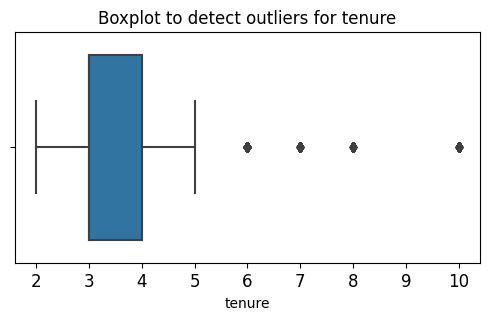

Number of rows with outliers in 'tenure': 824


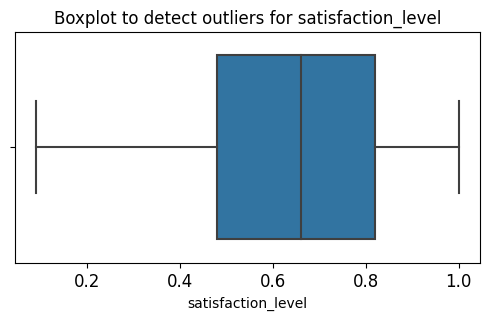

Number of rows with outliers in 'satisfaction_level': 0


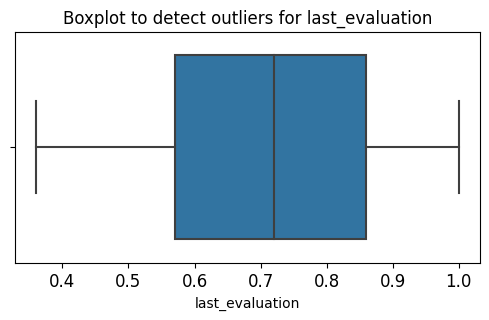

Number of rows with outliers in 'last_evaluation': 0


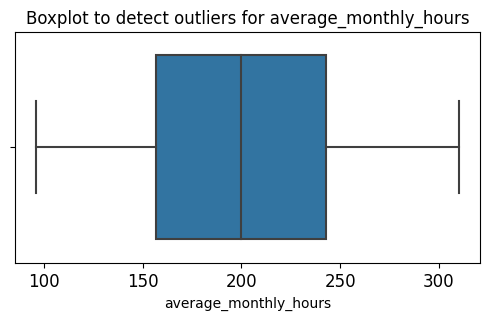

Number of rows with outliers in 'average_monthly_hours': 0


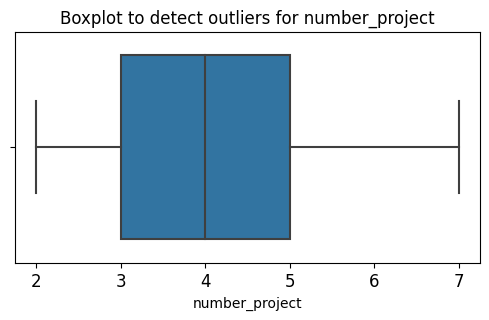

Number of rows with outliers in 'number_project': 0


In [14]:
def handle_outliers(df, feature):
    
    # Visualize the distribution of the feature
    plt.figure(figsize=(6,3))
    plt.title(f'Boxplot to detect outliers for {feature}', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.boxplot(x=df[feature])
    plt.show()

    # Identify outliers
    percentile25 = df[feature].quantile(0.25)
    percentile75 = df[feature].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    outliers = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)]
    print(f"Number of rows with outliers in '{feature}': {len(outliers)}")

    # Return the original DataFrame
    return df

# List of features to check for outliers
features = ['tenure', 'satisfaction_level', 'last_evaluation', 'average_monthly_hours', 'number_project']

# Iterate through the features and handle outliers
for feature in features:
    sfdf= handle_outliers(sfdf, feature)

While I anticipated outliers in multiple features, I was surprised to find them concentrated solely in the 'tenure' feature, with a significant count of 824 rows.

My next step is to continue EDA, as further exploration is crucial. I must delve deeper into the data and analyze the intricate connections between features to understand their impact on turnover. I'll start analyzing employee turnover by determining the number of employees who left and what proportion of the total workforce this represents.

In [15]:
# Employee turnover data. Reminder: 1= employee left, 0= employee did not leave
turnover_data = {
    'left': [0, 1],
    'count':  sfdf['left'].value_counts(),
    'percent': sfdf['left'].value_counts(normalize=True)
}

turnover_df = pd.DataFrame(turnover_data)
print(turnover_df)

      left  count   percent
left                       
0        0  10000  0.833959
1        1   1991  0.166041


83.39% of employees (10,000 out of 11,991) stayed with Salifort Motors. However, a notable 16.6% left during the time period the data represents. The dataset has a class imbalance, with far more employees who stayed than who employees who left. This is common in turnover analysis but important to keep in mind when building the machine learning models. While the overall retention rate seems high, understanding the reasons behind the 1,991 departures is crucial for Salifort to address turnover.

**Deeper Dive into EDA: Exploring Relationships with Employee Turnover**

In this section, I'll delve into various features within the Salifort employee dataset to understand how they might relate to employee turnover (target feature= 'left'). By visualizing these relationships, I'll be able to gain valuable insights that will guide my model building process.

* **Workload and Satisfaction**- Examine how workload (average_monthly_hours and number of projects) affects employee satisfaction and potentially contributes to turnover.
* **Tenure and Compensation**- Investigate satisfaction changes with tenure and uncover any pay discrepancies based on tenure or department that might influence employee decisions to leave.
* **Turnover and Other Factors**- Explore if factors like promotions, work accidents, and department affiliation have a bearing on employee departures.
* **Data Landscape Overview**- Correlations between features will be visualied to identify redundancy and explore the distribution of the target variable 'left' to understand the baseline proportion of employees who left the company.

Each relationship will be visualized using appropriate charts and graphs, followed by a discussion of the insights gained. This comprehensive exploration will provide a strong foundation for building my machine learning models to predict employee turnover.

The bottom line here is that better data understanding equals better machine learning models. This crucial step will lead to increased accuracy and better predictions.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

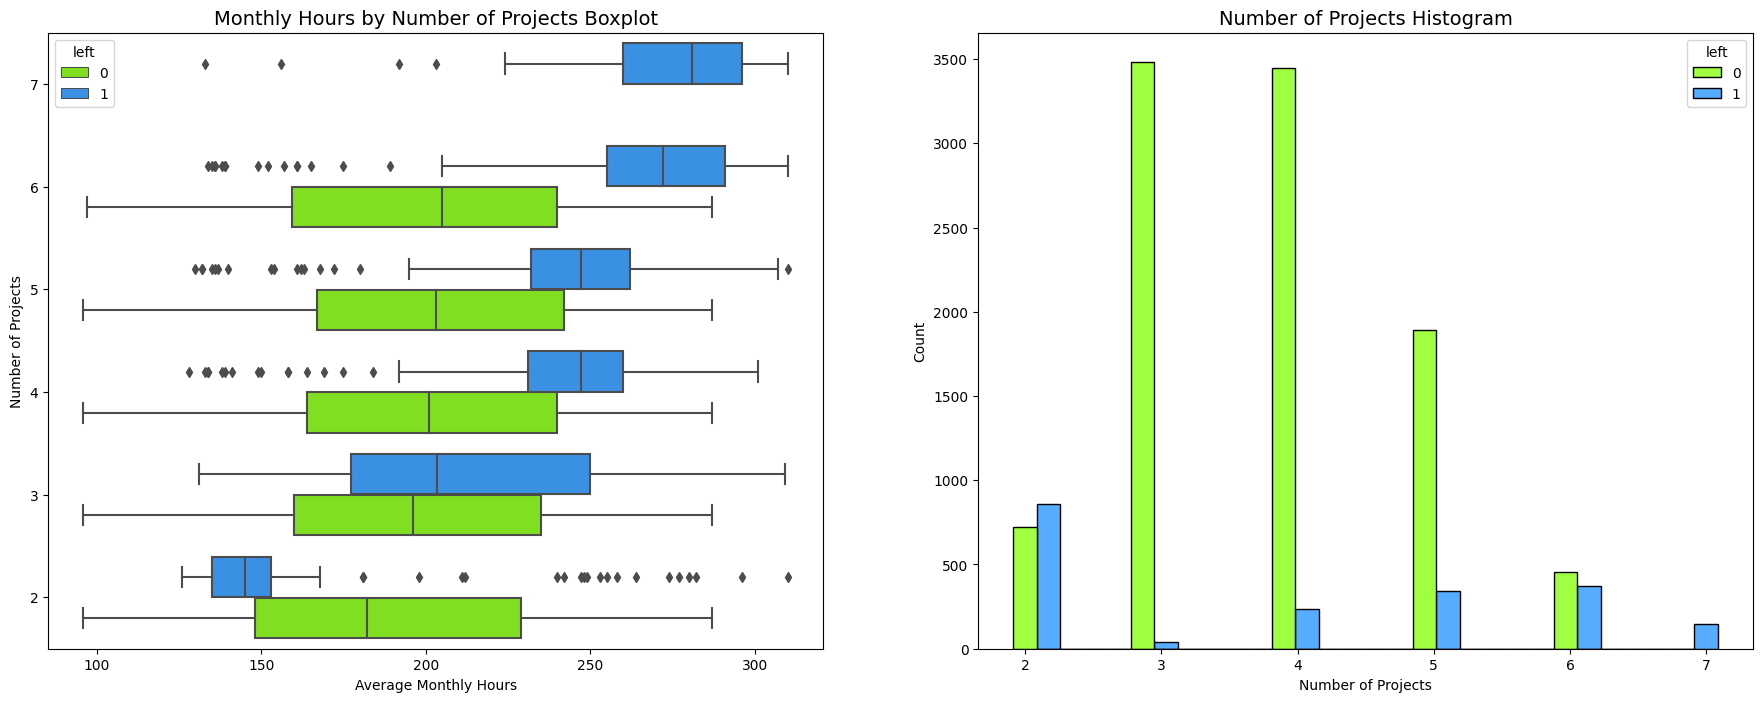

In [16]:
my_palette= ['chartreuse', 'dodgerblue']
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot 'average_monthly_hours'distribution for 'number_project'
sns.boxplot(data= sfdf, x='average_monthly_hours', y='number_project', hue='left', orient="h", palette= my_palette, ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_xlabel('Average Monthly Hours')
ax[0].set_ylabel('Number of Projects')
ax[0].set_title('Monthly Hours by Number of Projects Boxplot', fontsize='14')

# 'number_projet' Histogram depicting employee churn
tenure_stay = sfdf[sfdf['left'] == 0]['number_project']
tenure_left = sfdf[sfdf['left'] == 1]['number_project']
sns.histplot(data= sfdf, x='number_project', hue='left', multiple='dodge', shrink=2, palette= my_palette, ax=ax[1])
ax[1].set_xlabel('Number of Projects')
ax[1].set_ylabel('Count')
ax[1].set_title('Number of Projects Histogram', fontsize='14')

plt.show()

**Boxplot & Number of Project Histogram**

There's a a positive correlation between the number of projects and average monthly work hours. Employees assigned to more projects generally logged more hours. Interestingly, the data reveals two distinct groups of leavers. The **'Lower Hours Group'** worked significantly fewer hours than their peers with similar project loads. The **'Higher Hours Group'** logged considerably more hours than their peers. They were likely high contributors who may have felt overworked, leading to their resignation. Notably, all employees assigned to 7 projects left the company. The data suggests that a project assignment of 3-4 projects might be ideal for employee retention. The ratio of leavers to stayers is significantly lower for these groups compared to others.

Assuming a standard 40-hour work week with two weeks of annual vacation, the average monthly work hours for Monday-Friday employees translates to 166.7 hours/month. This indicates that, with the exception of the two-project group, all employee categories worked substantially more than the expected work hours. This suggests a potential issue with employee overwork and burnout. 

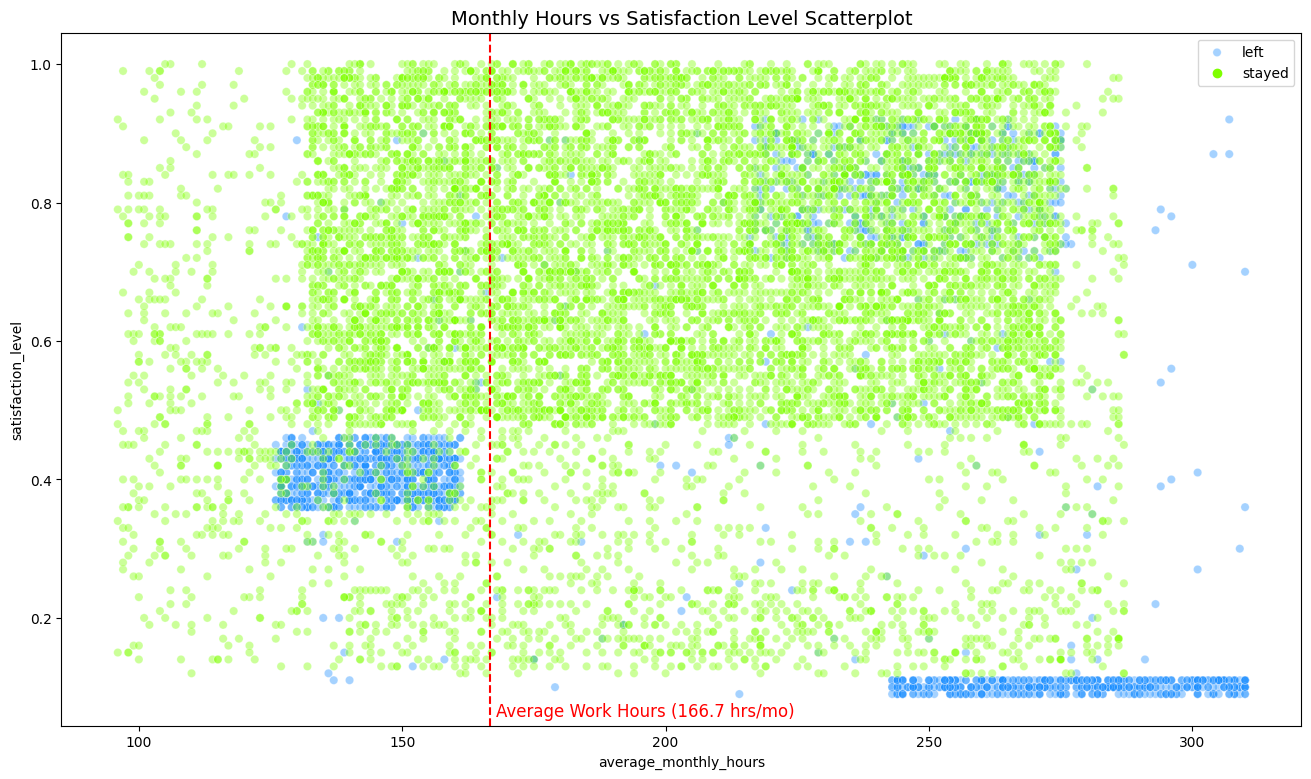

In [17]:
# 'average_monthly_hours' by 'last_evaluation' Scatterplot
my_palette= ['chartreuse', 'dodgerblue']
plt.figure(figsize=(16, 9))
sns.scatterplot(data= sfdf, x= 'average_monthly_hours', y= 'satisfaction_level', hue='left', palette= my_palette, alpha=0.4)
plt.axvline(x= 166.7, color= 'red', label='166.7 hrs/mo', linestyle= '--')
avg_work_hours= 166.7
plt.annotate('Average Work Hours (166.7 hrs/mo)', xy= (avg_work_hours + 1.1, 0.065), horizontalalignment='left', verticalalignment='center', fontsize=12, color='red') 
plt.legend(labels=['left', 'stayed'])
plt.title('Monthly Hours vs Satisfaction Level Scatterplot', fontsize='14')
plt.show()

**Avg.Monthly Hours vs Satisfaction Level Scatterplot**

This scatterpot highlights a complex relationship between workload, work hours, and employee satisfaction. A significant portion of employees worked exceptionally long hours, between 240-315 hours per month. This translates to over 75 hours per week sustained over extended periods. These employees also exhibit extremely low satisfaction levels (close to zero), suggesting a strong link between overwork and dissatisfaction (which makes perfect sense).

Interestingly, another group of employees left despite having more typical working hours. While their satisfaction levels were slightly higher (around 0.4), their departure raises questions.  Further investigation is needed to understand the potential causes, such as perceived pressure to overwork due to the company culture or other underlying factors affecting their job satisfaction.

Lastly, there's a group working 210-280 hours per month with satisfaction levels between 0.7-0.9. This group appears to have a healthier workload-satisfaction balance in comparison to the others.

The data's distributions reveal some truly unusual patterns, which warrant further investigation into possible data manipulation or the nature of the data source.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

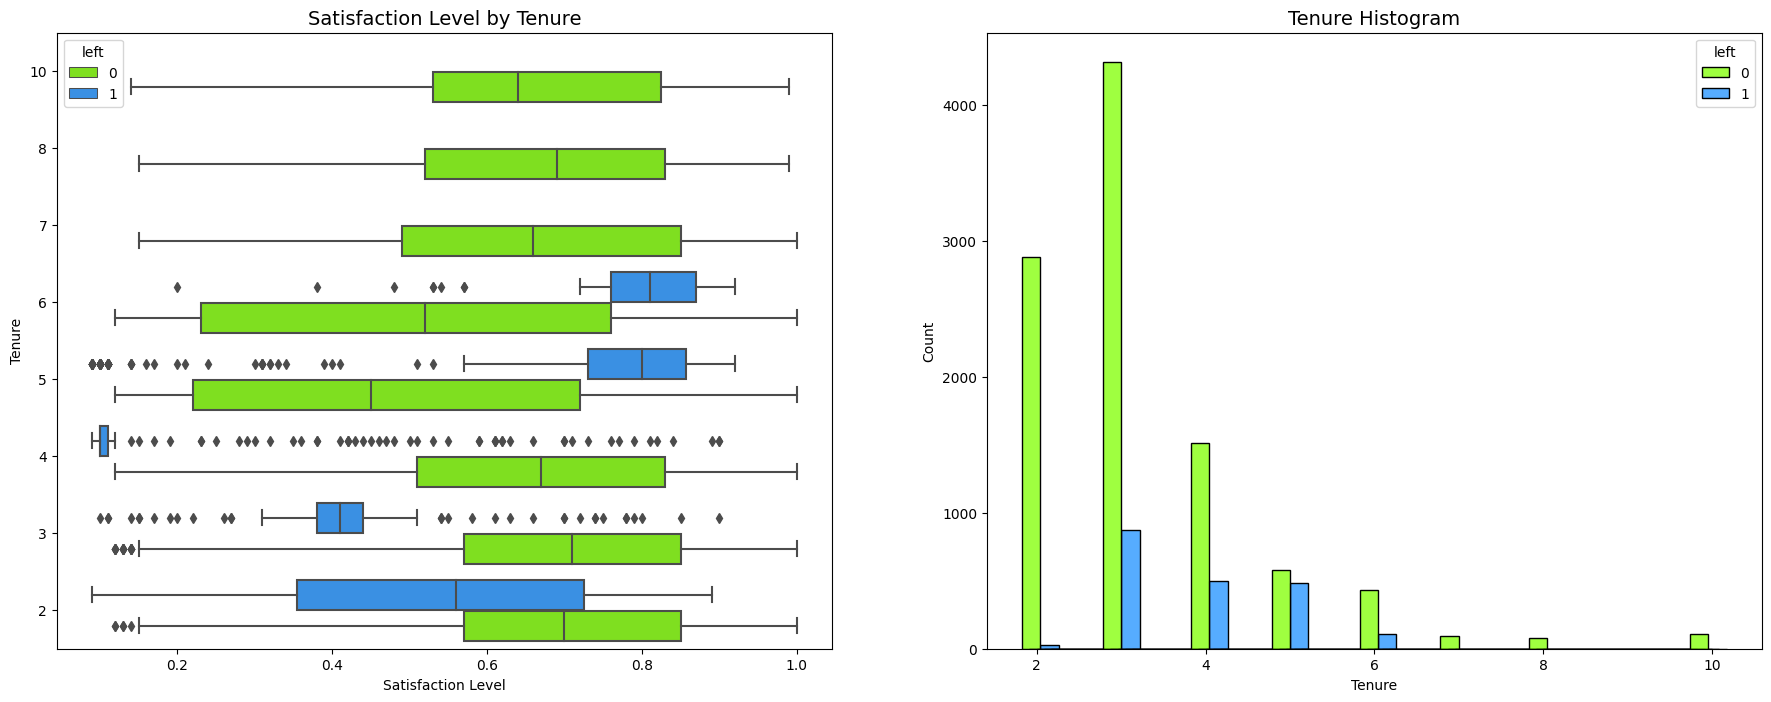

In [18]:
# Visualize satisfaction level by tenure
my_palette= ['chartreuse', 'dodgerblue']
fig, ax= plt.subplots(1, 2, figsize = (22,8))

# Boxplot `satisfaction_level` by tenure
sns.boxplot(data= sfdf, x='satisfaction_level', y='tenure', hue='left', orient="h", palette= my_palette, ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_xlabel('Satisfaction Level')
ax[0].set_ylabel('Tenure')
ax[0].set_title('Satisfaction Level by Tenure', fontsize='14')

# 'tenure' Histogram
tenure_stay= sfdf[sfdf['left'] == 0]['tenure']
tenure_left= sfdf[sfdf['left'] == 1]['tenure']
sns.histplot(data=sfdf, x='tenure', hue='left', multiple='dodge', shrink=5, palette= my_palette, ax=ax[1])
ax[1].set_xlabel('Tenure')
ax[1].set_ylabel('Count')
ax[1].set_title('Tenure Histogram', fontsize='14')

plt.show()

**Satisfaction by Tenure Histograms**

Analysis reveals two distinct groups of employees who left the company: those with shorter tenures expressing lower satisfaction levels, and employees with medium-length tenures who indicated surprisingly high satisfaction.

Employees with the longest tenure were more likely to stay with the company, and their satisfaction levels appear similar to those of newer employees who also remained employed. The histogram reveals a smaller proportion of employees with longer tenure, raising the possibility of a correlation between tenure and factors such as seniority and compensation levels

In [19]:
# Calculate mean and median
sfdf.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

/tmp/ipykernel_18/2855363167.py:2: FutureWarning: The provided callable <function mean at 0x791aa048c4c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sfdf.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
/tmp/ipykernel_18/2855363167.py:2: FutureWarning: The provided callable <function median at 0x791aa01bbbe0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  sfdf.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


**The Mean and the Median**

The mean and median satisfaction ratings of departing employees are lower compared to those who remain. Notably, within the group of retained employees, the average satisfaction score seems marginally lower than the median score. This suggests a potential left-skewed distribution in satisfaction levels among the retained workforce.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

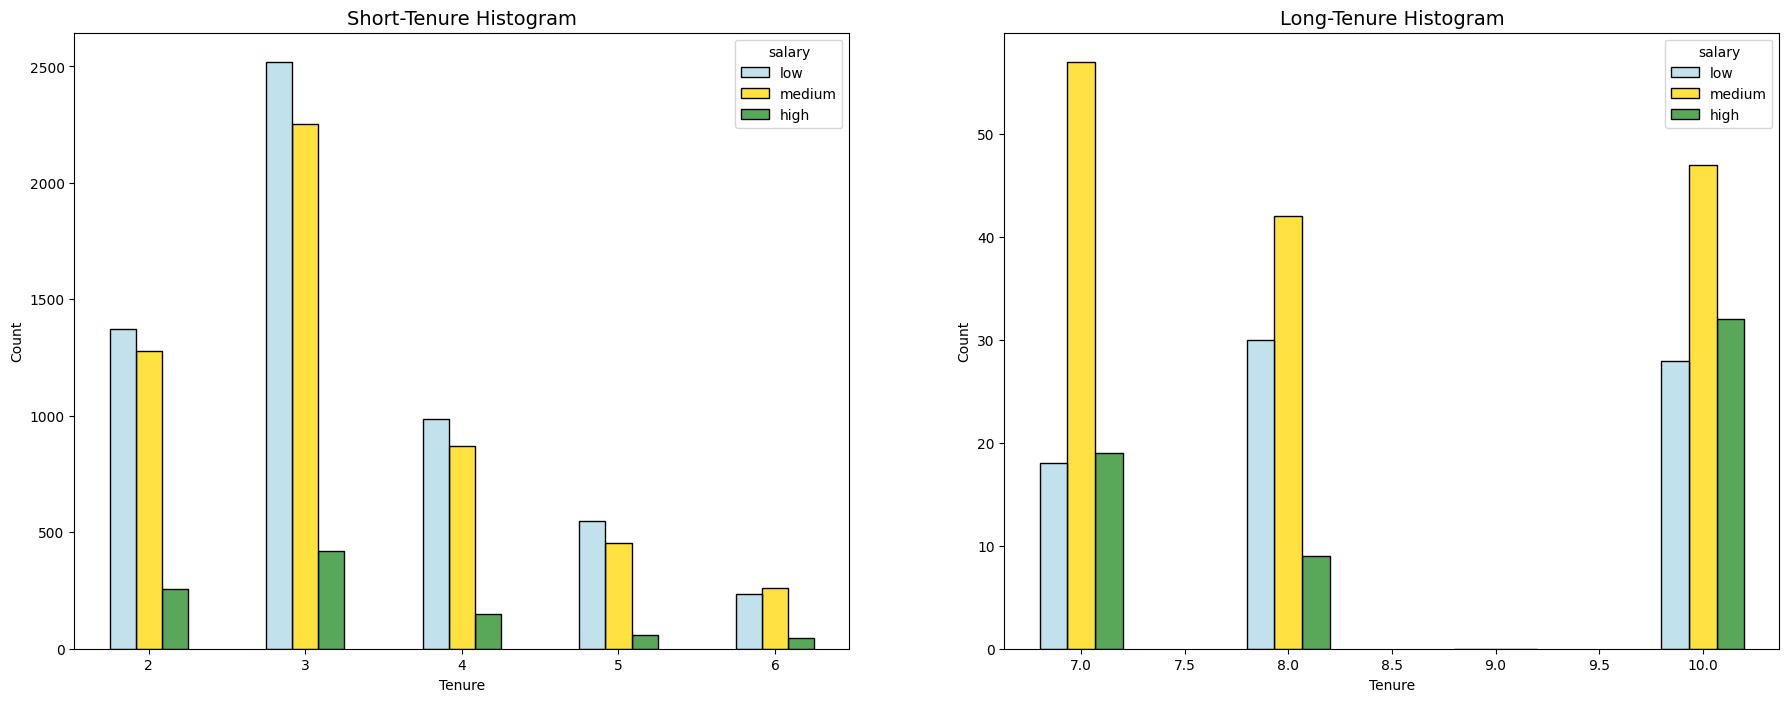

In [20]:
my_palette= ['lightblue', 'gold', 'forestgreen']
fig, ax = plt.subplots(1, 2, figsize = (22,8))

short_tenure= sfdf[sfdf['tenure'] < 7]
long_tenure= sfdf[sfdf['tenure'] > 6]

# Short-tenure Histogram
sns.histplot(data= short_tenure, x= 'tenure', hue= 'salary', discrete= True, hue_order= ['low', 'medium', 'high'], multiple='dodge', shrink=.5, palette= my_palette, ax=ax[0])
ax[0].set_xlabel('Tenure')
ax[0].set_ylabel('Count')
ax[0].set_title('Short-Tenure Histogram', fontsize='14')

# Long tenure Histogram
sns.histplot(data= long_tenure, x= 'tenure', hue= 'salary', discrete=True, hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, palette= my_palette, ax=ax[1])
ax[1].set_xlabel('Tenure')
ax[1].set_ylabel('Count')
ax[1].set_title('Long-Tenure Histogram', fontsize='14')
plt.show()

**Salaries by Tenure Histograms**

The histograms reveal similar shapes across all salary categories ('low', 'medium', and 'high') for both short and long tenures. This suggests that the distribution of salaries at different tenure levels might be relatively consistent.

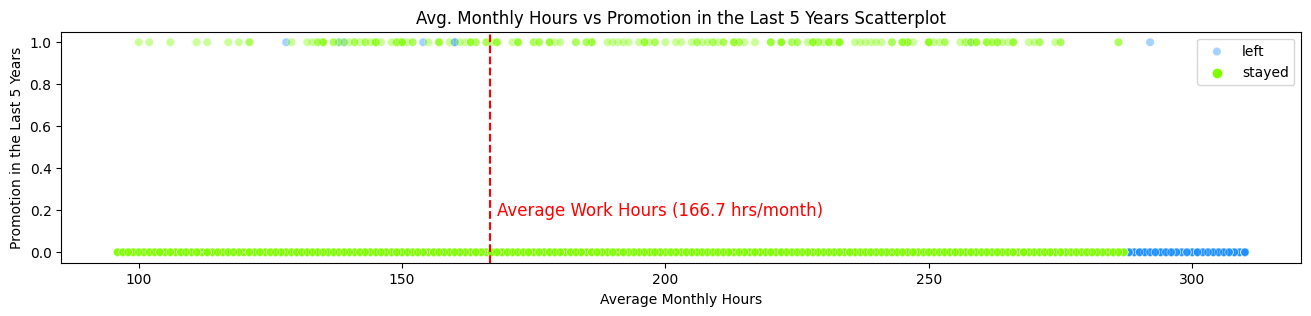

In [21]:
# 'average_monthly_hours' vs 'promotion_last_5years' Scatterplot
my_palette= ['chartreuse', 'dodgerblue']
plt.figure(figsize=(16,3))
sns.scatterplot(data= sfdf, x= 'average_monthly_hours', y= 'promotion_last_5years', hue= 'left', alpha= 0.4, palette= my_palette)
plt.axvline(x= 166.7, color= 'red', linestyle= '--')
plt.annotate('Average Work Hours (166.7 hrs/month)', xy= (168,0.2), horizontalalignment= 'left', verticalalignment= 'center', fontsize= 12, color= 'red')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Promotion in the Last 5 Years')
plt.title('Avg. Monthly Hours vs Promotion in the Last 5 Years Scatterplot')
plt.legend(labels= ['left','stayed'])
plt.show()

**Avg. Monthly Hours vs Promotion in the last 5 Years Scatterplot**

Employees who worked longer hours (above the average of 166.7 hrs/month) were more likely to leave the company. The majority of the blue dots, representing employees who left, are concentrated on the right side of the plot, indicating higher average monthly hours. Conversely, employees who worked fewer hours (below the average of 166.7 hrs/month) were less likely to leave the company. The green dots, representing employees who stayed, are more prevalent on the left side of the plot, indicating lower average monthly hours.

There appears to be a positive correlation between average monthly hours and the likelihood of leaving the company (employee churn). As the average monthly hours increase, the proportion of employees who left (blue dots) also increases. However, it's important to note that working longer hours does not necessarily lead to employees leaving. There are still some data points representing employees who worked longer hours but stayed with the company. Similarly, there are a few employees who worked fewer hours but still left the company (blue dots on the left side of the plot), suggesting that while longer hours may contribute to employee churn, other factors might also play a role.

In conclusion, this scatterplot suggests a positive relationship between average monthly hours and the likelihood of employees leaving the company (churn). Employees who put in more hours tend to have a higher risk of churning, although this pattern is not absolute, and other factors may also influence employee retention. The insights from this analysis could help inform policies and practices related to workload management, work-life balance, and employee retention strategies within the organization.

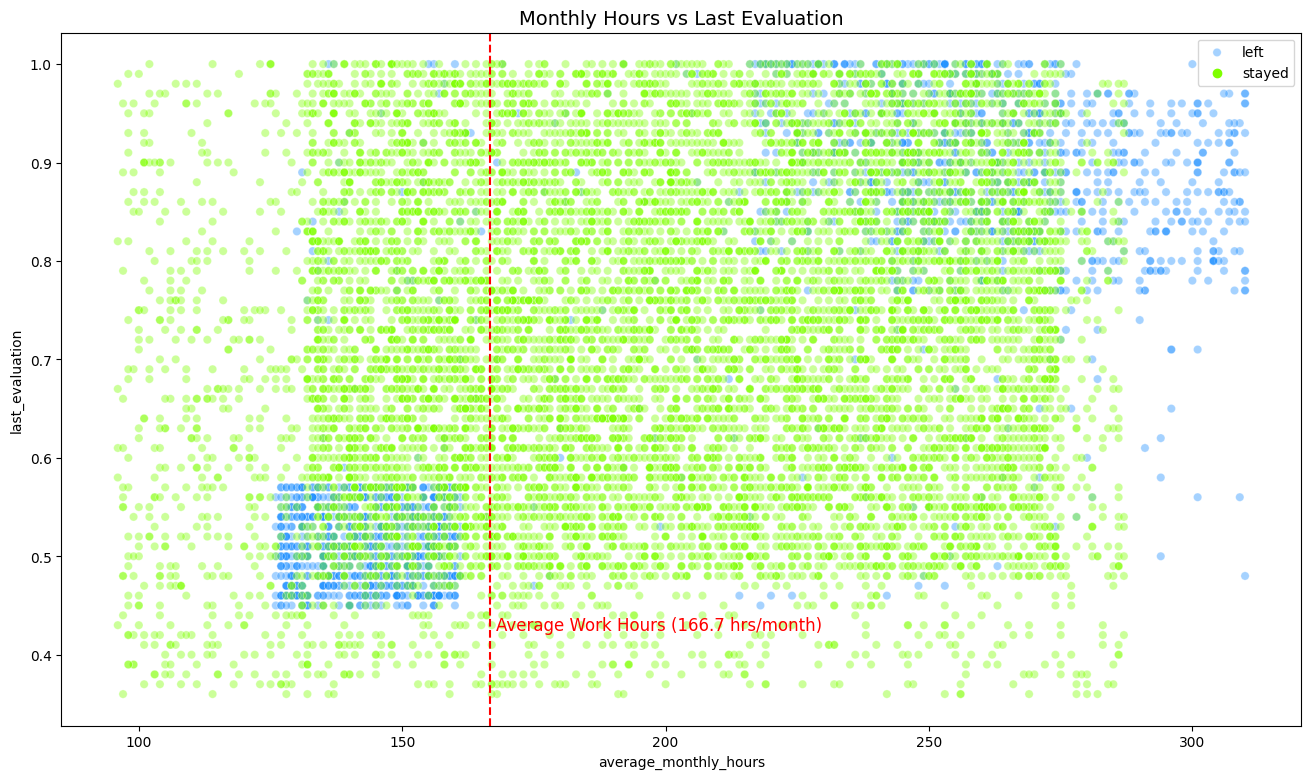

In [22]:
# 'average_monthly_hours' vs 'last_evaluation' Scatterplot
my_palette= ['chartreuse', 'dodgerblue']
plt.figure(figsize=(16, 9))
sns.scatterplot(data= sfdf, x= 'average_monthly_hours', y= 'last_evaluation', hue='left', palette= my_palette, alpha=0.4)
plt.axvline(x=166.7, color='red', label='166.67 hrs/mo', linestyle='--')
avg_work_hours= 166.7
plt.annotate('Average Work Hours (166.7 hrs/month)', xy= (avg_work_hours + 1.1,0.43), horizontalalignment= 'left', verticalalignment= 'center', fontsize= 12, color= 'red')
plt.legend(labels=['left', 'stayed'])
plt.title('Monthly Hours vs Last Evaluation', fontsize='14')
plt.show()

**Avg. Monthly Hours vs. Last Evaluation Scatterplot**

The data points are scattered, indicating no strong linear relationship between average monthly work hours and last evaluation scores. Employees who worked longer hours don't necessarily have consistently higher or lower evaluation scores, and vice versa.

A cluster of points in the lower left corner suggests that some employees with lower work hours also received lower evaluations. This could be due to a lack of initiative or required skills, or it might reflect poorly defined job roles where expectations are unclear.

A possible cluster in the upper right corner indicates employees who worked very long hours and received high evaluations. These could be high performers who are dedicated to their work, or they might be stuck on complex projects requiring extra effort.

The majority of the data points appear concentrated in the center area, with a mix of work hours and evaluation scores. This suggests that for most employees, work hours alone aren't a determining factor in performance reviews and they don't gaurantee success.

The majority of the workforce work well beyond the 167 hour average, which could mean Salifort Motors has a dedicated workforce or maybe the dataset represents a high-demand period. On the other hand, this could also mean that there is overwork culture leading to burnout, or maybe an iadqueate staff that isn't being delegated correctly.

In [23]:
# Employees distribution across all departments
sfdf['department'].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

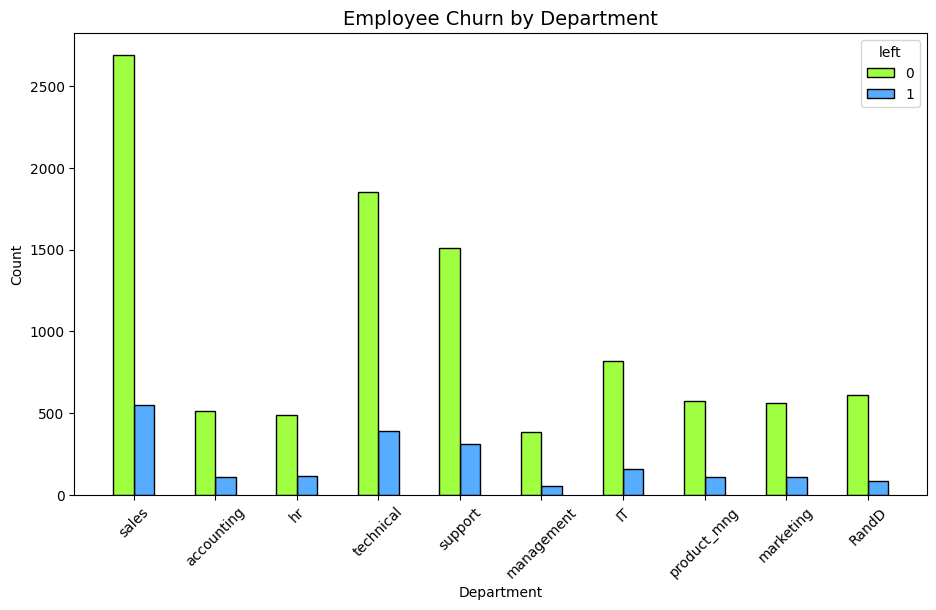

In [24]:
# Department Histogram
my_palette= ['chartreuse', 'dodgerblue']
plt.figure(figsize=(11,6))
sns.histplot(data= sfdf, x= 'department', hue= 'left', discrete= True, hue_order=[0, 1], multiple='dodge', shrink=.5, palette= my_palette)
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation= 45)
plt.title('Employee Churn by Department', fontsize=14)
plt.show()

**Department Histogram**

The Sales, Technical and Support departments experienced the highest number of employee departures compared to other departments. On the other hand, departments like Management, IT, HR, and RandD had very few employee departures. The histogram indicates that employee retention is a challenge for the Sales and Technical departments, while other areas like IT, HR, and RandD have been more successful in retaining their workforce.

The histogram highlights the potential areas of concern regarding employee attrition and the departments that may require focused efforts to improve retention strategies, employee engagement, and address factors contributing to high turnover rates. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

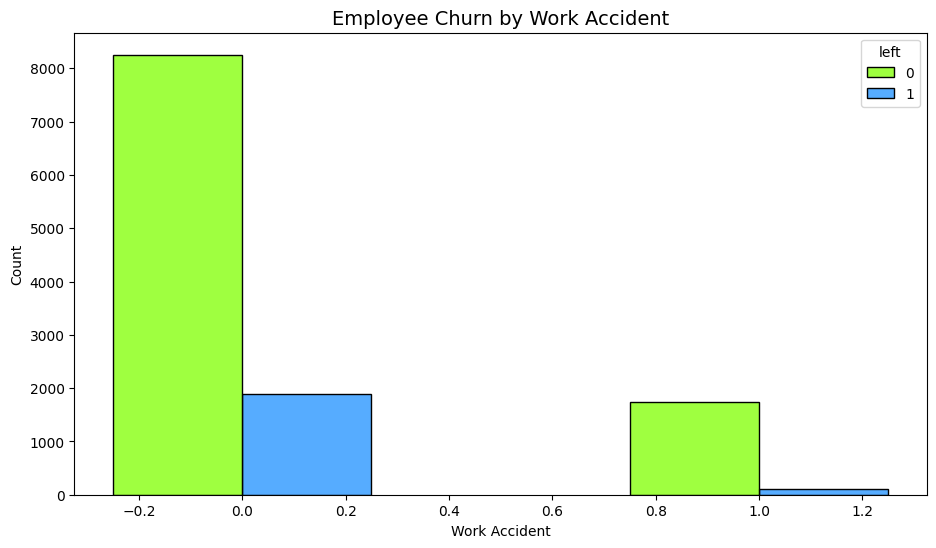

In [25]:
# Employee Churn by Work Accidents
my_palette= ['chartreuse', 'dodgerblue']
plt.figure(figsize=(11,6))
sns.histplot(data= sfdf, x= 'work_accident', hue= 'left', discrete= True, hue_order=[0, 1], multiple='dodge', shrink=.5, palette= my_palette)
plt.xlabel('Work Accident')
plt.ylabel('Count')
plt.title('Employee Churn by Work Accident', fontsize=14)
plt.show()

**Employee Churn by Work Accident**

It's reasonable to say that this particular chart showing employee churn by work accident does not have direct significance or relevance in determining or training the machine learning models I plan to create for this project. Unfortunately, this approach did not yield any desired or significant insights.

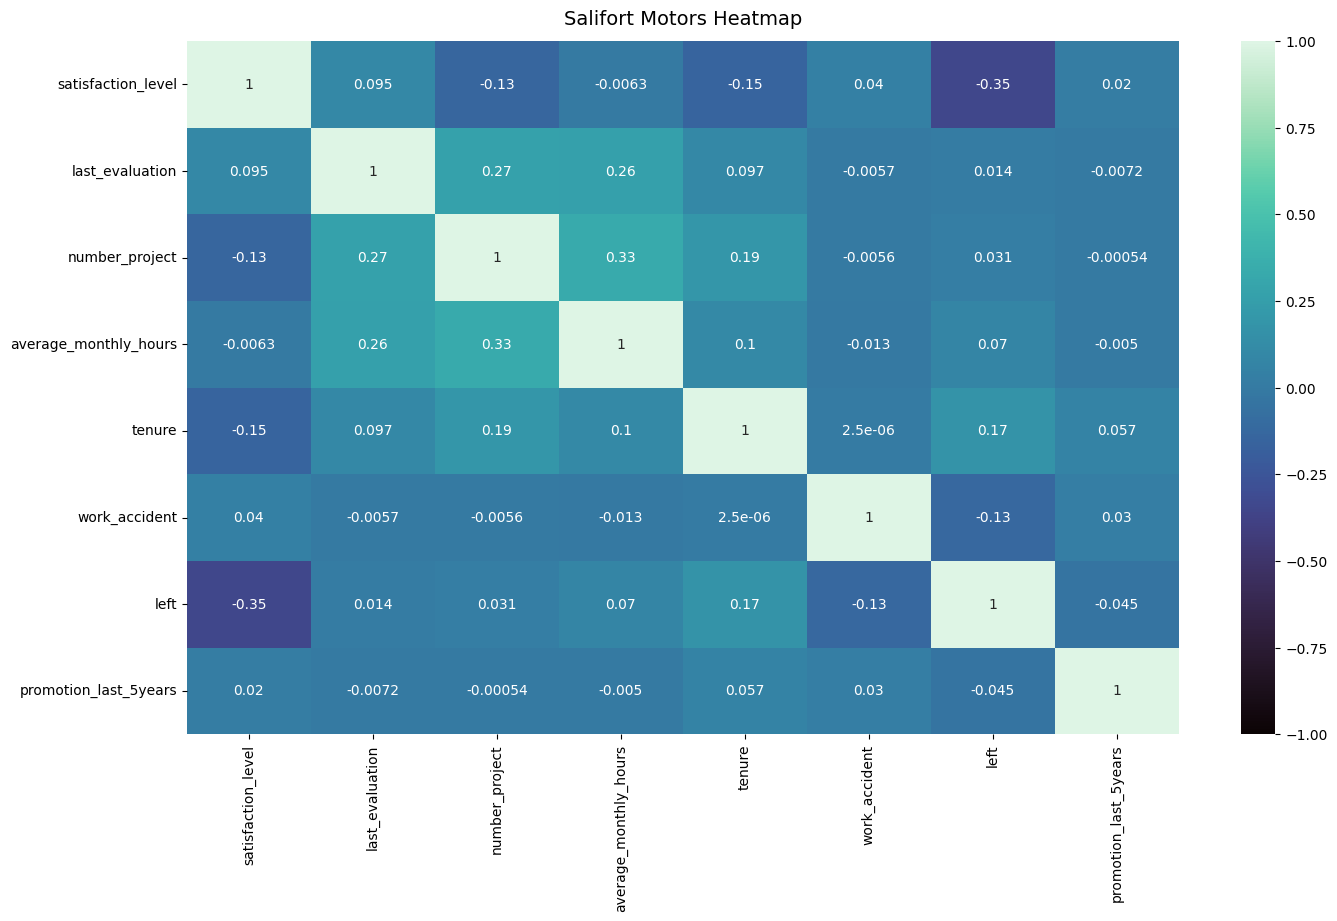

In [26]:
# Salifort Motors Heatmap
numeric_cols= sfdf.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(numeric_cols.corr(), vmin=-1, vmax=1, annot=True, cmap= sns.color_palette('mako', as_cmap= True))
heatmap.set_title('Salifort Motors Heatmap', fontdict={'fontsize':14}, pad=12);

**Salifort Motors Heatmap**

Overall, this heatmap provides valuable insights into the relationships between various employee attributes, performance factors, and retention at Sailfort Motors, which can inform decision-making strategies related to employee satisfaction, safety, workload management, and retention efforts. For example, the correlation heatmap analysis reveals positive correlations between the number of projects undertaken, the number of monthly work hours, and employee evaluation scores. Conversely, employee satisfaction level exhibits a negative correlation with their likelihood of leaving the company.

**Insights of EDA**

Employee turnover analysis reveals a correlation between high workload (longer hours, multiple projects) and lower job satisfaction, potentially indicating management practices requiring review. Salifort Motors may be experiencing a culture of overwork and burnout.  Additionally, the data suggests a potential positive correlation between tenure and employee retention, with employees exceeding six years at the company exhibiting lower turnover rates. 

**Model I- Logistic Regression**

My first model is going to be a logistic regression model, which is a suitable choice for developing a model to predict employee churn at Salifort Motors. Churn prediction is a binary classification problem, where the goal is to determine whether an employee will stay or leave the company based on various factors. Logistic regression is a powerful statistical technique that excels at modeling binary outcomes, making it an appropriate choice for this task.

In the process of preparing the data for modeling, it is crucial to handle the non-numeric variables appropriately. In this case, there are two such variables: 'department' and 'salary'. These variables need to be encoded or transformed into a numerical format suitable for the machine learning algorithm.

The 'department' variable is categorical, meaning that its values represent distinct categories or groups without any inherent order or ranking. To incorporate categorical variables into the model, a common technique is to create dummy variables through a process called one-hot encoding. This approach transforms the single categorical variable into multiple binary columns, each representing one category.

On the other hand, the 'salary' variable is also categorical, but it is an ordinal variable. Ordinal variables have categories that follow a specific order or hierarchy. For instance, the categories of the 'salary' variable are "low," "medium," and "high," which have an inherent ranking. In such cases, it is better to convert the levels or categories into numerical values that preserve the ordinal relationship, rather than creating dummy variables. This approach retains the inherent ordering information, which will be valuable for the model. 

In [27]:
# View dataset
sf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [28]:
# Copy the dataframe
sfdf_encode= sf.copy()
sfdf_encode.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [29]:
# Encode 'salary column'
sfdf_encode['salary'] = (sfdf_encode['salary'].astype('category') .cat.set_categories(['low', 'medium', 'high']).cat.codes)

# Encode 'department' column
sfdf_encode= pd.get_dummies(sfdf_encode, drop_first= False)

sfdf_encode.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


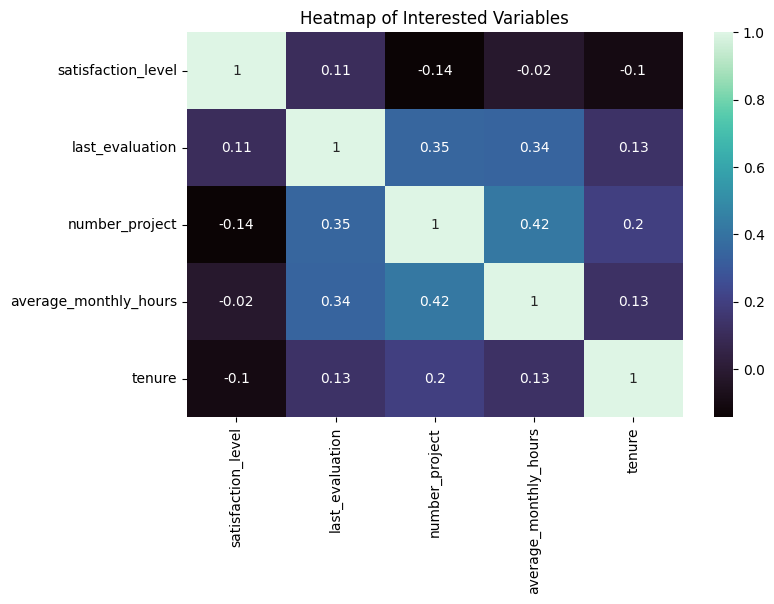

In [30]:
# Heatmap of interested variables
plt.figure(figsize=(8,5))
sns.heatmap(sfdf_encode[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap="mako")
plt.title('Heatmap of Interested Variables')
plt.show()

Logistic regression models are sensitive to outliers. Outliers, which are data points that significantly deviate from the overall pattern of the data, can distort the model, leading to biased parameter estimates and reduced model performance. Earlier boxplot analysis revealed that the 'tenure' feature exhibits 824 outliers. By removing outliers from the 'tenure' column, I aim to improve the model's robustness and ensure its effectivenes.

In [31]:
# Identify outliers
percentile25 = sfdf_encode['tenure'].quantile(0.25)
percentile75 = sfdf_encode['tenure'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Remove 'tenure' outliers
lrsf= sfdf_encode[(sfdf_encode['tenure'] >= lower_limit) & (sfdf_encode['tenure'] <= upper_limit)]
lrsf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [32]:
# Isolate target feature
y= lrsf['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [33]:
# Features for the model
X= lrsf.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [34]:
# Split data into training and test test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 42)

In [35]:
# Build logistic regression model an fit into training data
lr_clf= LogisticRegression(random_state= 42, max_iter= 500).fit(X_train, y_train)

In [36]:
# Prediction on test set
y_pred= lr_clf.predict(X_test)

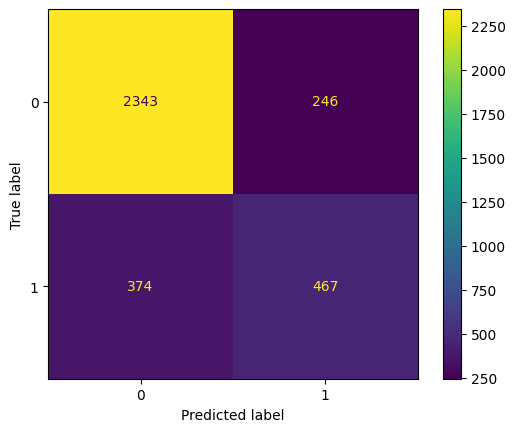

In [37]:
# Confusion Matrix
lr_cm= confusion_matrix(y_test, y_pred, labels= lr_clf.classes_)
lr_disp= ConfusionMatrixDisplay(confusion_matrix= lr_cm, display_labels= lr_clf.classes_)
lr_disp.plot(values_format= '')
plt.show()

**Confusion Matrix**

The confusion matrix is a table that visually summarizes the performance of a classification model. It shows the number of correct and incorrect predictions made by the model. The quadrants demonstrate the following:

* **Upper Left Quadrant**- True Negatives. 2343 represents the number of employees who didn't leave that the model accurately predicted didn't leave
* **Upper Right Quadrant**- False Positives. 247 represents the number of employees who didn't leave that the model predicted as leaving.
* **Bottom Left Quadrant**- False Negatives. 394 represents the number of employees who left that the model inaccurately prediced didn't leave. 
* **Bottom Right Quadrant**- True Positives. 447 represents the number of employees who left that the model accurately predicted as leaving. 


In [38]:
# Check class balance
lrsf['left'].value_counts(normalize= True)

left
0    0.754903
1    0.245097
Name: proportion, dtype: float64

The class balance for the logistic regression model seems slightly imbalanced, with approximately 75.5% of the observations belonging to class 0 (employees who did not leave) and around 24.5% belonging to class 1 (employees who left).

In [39]:
# Classification report for logistic regression model
names= ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test,y_pred, target_names= names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.90      0.88      2589
    Predicted would leave       0.65      0.56      0.60       841

                 accuracy                           0.82      3430
                macro avg       0.76      0.73      0.74      3430
             weighted avg       0.81      0.82      0.81      3430



**Logistic Regression Model**

* **Precision**- The precision for predicting "would not leave" is relatively high at 86%, indicating that when the model predicts that an employee would not leave, it's correct about 86% of the time. However, the precision for predicting "would leave" is lower at 44%, suggesting that the model has a higher rate of false positives.

* **Recall**- The recall for predicting "would not leave" is high at 93%, meaning that the model correctly identifies about 93% of the employees who actually did not leave. However, the recall for predicting "would leave" is lower at 26%, indicating that the model misses a significant portion of employees who actually left.

* **F1-Score**- The F1-score, which balances precision and recall, is 90% for "would not leave" and 33% for "would leave". The lower F1-score for "would leave" reflects the imbalance between precision and recall in that class.

* **Accuracy**- The overall accuracy of the model is 82%, which indicates the proportion of correctly predicted outcomes among all predictions.

* **Macro Average**- The macro-average of precision, recall, and F1-score is around 65%, suggesting moderate performance across both classes.

* **Weighted Average**- The weighted-average F1-score, which considers class imbalance, is around 80%, indicating a decent overall performance of the model. However, it's important to note the class imbalance and the trade-offs between precision and recall, especially for the "would leave" class.


Overall, this logistic regression model demonstrates moderate performance. It achieves a reasonably high accuracy of 82%, indicating that it correctly predicts the outcome for about 82% of the cases. However, there are notable disparities in performance between the two classes. While the model shows strong precision and recall for predicting "would not leave," with high values of 86% and 93% respectively, its performance for predicting "would leave" is less satisfactory, with lower precision (44%) and recall (26%). This suggests that the model struggles more with correctly identifying employees who actually left the company. The F1-scores further highlight this imbalance, with a significantly lower score for "would leave." Despite these shortcomings, the weighted average F1-score of 80% indicates decent overall performance, considering the class imbalance. Therefore, while the model demonstrates room for improvement, it still provides valuable insights into employee churn prediction.